# Introduction to data analysis - part 3: weather and pollutants

## 1. Today's objectives

- and what about mixing wind and pollutants?
    - windroses - pollutant roses...

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns

### 2. to work!

Don't forget the [advanced Cheat-Sheet](../aide/Enthought-Python-Pandas-Cheat-Sheets-1-8-v1.0.2.pdf)...

first, we recover the data we just pretreated. Either from the file you created when you did the pre-treatment, or from `../data/data_airrhonalpes_part2.csv` that got pulled from the repository when you initiated the sequence

- **complete the following cell to upload the file properly into `dfc`... options are the key!**

- **if you did things right, columns should be numeric data, and the index should be a `DatetimeIndex`, not an index of `dtype'object'`**

- **you will then select a subset of the data into `mon_df`, on which you'll work afterwards (ex: one pollutant in all the stations, or all the pollutants in one station, or whichever choice suits you...)**

In [2]:
dfc = pd.read_csv('../data/clean_data_p2.csv',sep=';', low_memory=False,
                  header=[0,1], index_col=0, parse_dates=True)

print(dfc.index)

mon_df = dfc['Campus']

DatetimeIndex(['2010-07-01 00:00:00', '2010-07-01 01:00:00',
               '2010-07-01 02:00:00', '2010-07-01 03:00:00',
               '2010-07-01 04:00:00', '2010-07-01 05:00:00',
               '2010-07-01 06:00:00', '2010-07-01 07:00:00',
               '2010-07-01 08:00:00', '2010-07-01 09:00:00',
               ...
               '2015-12-31 15:00:00', '2015-12-31 16:00:00',
               '2015-12-31 17:00:00', '2015-12-31 18:00:00',
               '2015-12-31 19:00:00', '2015-12-31 20:00:00',
               '2015-12-31 21:00:00', '2015-12-31 22:00:00',
               '2015-12-31 23:00:00', '2016-01-01 00:00:00'],
              dtype='datetime64[ns]', length=48242, freq=None)


## 3. Combination of weather and air quality

We have data from weather stations next to some air quality stations. These data are quite diverse in their origins. So the import step is quite painful. And I give it completely 

![](../aide/carte-grenoble.png)

For those who have no former experience with importing data in pandas, it will provide a variety of examples

### 3.1. Get weather data

#### 3.1.1. The roof of IGE

we have a quite complete weather station on our roof in Saint-Martin-d'Hères

In [3]:
#récupération des données du CERMO ( ~ station SMH)
mto_CERMO_name = "../data/MTO-CERMO_10min_2008-2016.csv"

mto_CERMO = pd.read_csv(mto_CERMO_name,sep=';',index_col=0, low_memory=False, parse_dates=True, dayfirst=True)
print ('data loaded')
def convert(x):
    try:
        y = float(x)
    except ValueError:
        print('bug:',x)
        y = np.nan
    return y

object_cols = [col for col in mto_CERMO.columns  if mto_CERMO[col].dtypes == 'object']
for col in object_cols:
    mto_CERMO[col] = mto_CERMO[col].apply(convert)#???

print(mto_CERMO.info())
mto_CERMO.head()

data loaded
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 419622 entries, 2008-07-28 15:10:00 to 2016-07-20 16:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Patm (mbar)     416825 non-null  float64
 1   Rg (W/m2)       416879 non-null  float64
 2   Tair (C)        416875 non-null  float64
 3   HR (%)          416876 non-null  float64
 4   V Vent (m/s)    416876 non-null  float64
 5   Dir Vent (Deg)  416876 non-null  float64
 6   Pluie (mm)      416887 non-null  float64
dtypes: float64(7)
memory usage: 25.6 MB
None


Patm (mbar)  Rg (W/m2)  Tair (C)  HR (%)  V Vent (m/s)  \
Date et heure                                                                 
2008-07-28 15:10:00       998.18      528.2     33.12   35.98         0.654   
2008-07-28 15:20:00       998.14      657.6     35.29   30.30         0.423   
2008-07-28 15:30:00       998.05      640.6     36.09   29.05         0.650   
2008-07-28 15:40:00       998.05      573.3     35.98   29.27         0.710   
2008-07-28 15:50:00       998.02      521.1     34.61   33.06         0.772   

                     Dir Vent (Deg)  Pluie (mm)  
Date et heure                                    
2008-07-28 15:10:00          225.20         0.0  
2008-07-28 15:20:00          251.30         0.0  
2008-07-28 15:30:00          215.80         0.0  
2008-07-28 15:40:00          333.40         0.0  
2008-07-28 15:50:00            8.52         0.0

this needs to be resampled on an hourly basis...

**do it!**

In [4]:
## your code here (use .resample(...) )
mto_CERMO = mto_CERMO.resample('H').mean()

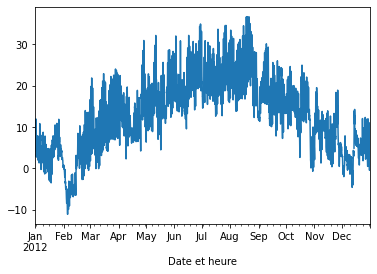

In [5]:
# Check the air temperature of one year to make sure everything is ok!
mto_CERMO['Tair (C)']['2012'].plot()

#### 3.1.2. Some data from AirRhoneAlpes

These are for a big roadside site, south of Grenbole. This is the site called Rocade in the air quality dataset, and is called Rondeau here; it also has data from another station further south (Pont-de-Claix), not far from the one called Vif in the air quality dataset

these data are within an excel file !!!

sure, you could open it in excel, strip it from any useless decorations, save it as CSV...

or you open it directly from pandas ! 

If you get an error for reading the file, try to add the option: `engine='openpyxl'` (https://stackoverflow.com/questions/65254535/xlrd-biffh-xlrderror-excel-xlsx-file-not-supported)

In [6]:
#récupération des données air-rhone-alpes : Rocade et Pont-de-Claix (~ station Vif ?)

mto_airAURA_name = "../data/3592_Donnees_meteo_Grenoble.xlsx"
mto_airAURA = pd.read_excel(mto_airAURA_name, 
                            sheet_name=0, 
                            header=[23,24], 
                            index_col=0,
                            engine='openpyxl')

mto_airAURA.index = pd.to_datetime(mto_airAURA.index, dayfirst=True)

mto_airAURA = mto_airAURA.iloc[:, :6] # In case too much columns
print(mto_airAURA.info())
mto_airAURA.head()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56952 entries, 2010-01-01 01:00:00 to 2016-07-01 00:00:00
Data columns (total 6 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   (Le Rondeau, Température (°C))               56331 non-null  float64
 1   (Le Rondeau, Vitesse du Vent (m/s))          55790 non-null  float64
 2   (Le Rondeau, Direction du Vent (Degrés))     55790 non-null  float64
 3   (Pont de Claix, Température (°C))            53269 non-null  float64
 4   (Pont de Claix, Vitesse du Vent (m/s))       53703 non-null  float64
 5   (Pont de Claix, Direction du Vent (Degrés))  53703 non-null  float64
dtypes: float64(6)
memory usage: 3.0 MB
None


Le Rondeau                        \
Dates               Température (°C) Vitesse du Vent (m/s)   
2010-01-01 01:00:00              5.3                   0.3   
2010-01-01 02:00:00              5.3                   0.5   
2010-01-01 03:00:00              5.3                   0.4   
2010-01-01 04:00:00              5.3                   0.7   
2010-01-01 05:00:00              5.6                   0.3   

                                                  Pont de Claix  \
Dates               Direction du Vent (Degrés) Température (°C)   
2010-01-01 01:00:00                      116.0              2.4   
2010-01-01 02:00:00                      173.0              2.6   
2010-01-01 03:00:00                      100.0              2.7   
2010-01-01 04:00:00                      127.0              3.0   
2010-01-01 05:00:00                      129.0              3.4   

                                                                      
Dates               Vitesse du Vent (m/s) Direction du Vent (Degrés)  
2010-01-01 01:00:00                   1.0                      187.0  
2010-01-01 02:00:00                   0.1                      294.0  
2010-01-01 03:00:00                   0.1                      213.0  
2010-01-01 04:00:00                   0.9                      165.0  
2010-01-01 05:00:00                   0.2                      215.0

OK, we need to change the station names so that they fit with the air quality data

In [7]:
mto_airAURA.rename(columns = {'Le Rondeau':'Rocade', 'Pont de Claix':'PdC'}, 
                   level = 0, inplace = True)
#notice that we have to specify level, as we have a multilevel index here
    
mto_airAURA.head()

Rocade                        \
Dates               Température (°C) Vitesse du Vent (m/s)   
2010-01-01 01:00:00              5.3                   0.3   
2010-01-01 02:00:00              5.3                   0.5   
2010-01-01 03:00:00              5.3                   0.4   
2010-01-01 04:00:00              5.3                   0.7   
2010-01-01 05:00:00              5.6                   0.3   

                                                            PdC  \
Dates               Direction du Vent (Degrés) Température (°C)   
2010-01-01 01:00:00                      116.0              2.4   
2010-01-01 02:00:00                      173.0              2.6   
2010-01-01 03:00:00                      100.0              2.7   
2010-01-01 04:00:00                      127.0              3.0   
2010-01-01 05:00:00                      129.0              3.4   

                                                                      
Dates               Vitesse du Vent (m/s) Direction du Vent (Degrés)  
2010-01-01 01:00:00                   1.0                      187.0  
2010-01-01 02:00:00                   0.1                      294.0  
2010-01-01 03:00:00                   0.1                      213.0  
2010-01-01 04:00:00                   0.9                      165.0  
2010-01-01 05:00:00                   0.2                      215.0

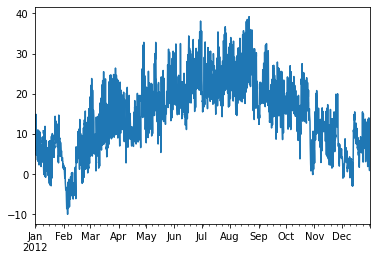

In [8]:
# Check the air temperature of one year to make sure everything is ok!
mto_airAURA['Rocade']['Température (°C)']['2012'].plot()

#### 3.1.3. Météo France

Last... data from meteofrance, concerning one site north of Grenoble (Le Versoud for weather, Crolles for Air Quality) and another west of Grenoble (called StGeoirs for weather, and Bonnevaux for Air Quality)

the [description of the dataset is here](../data/data-dda-description.pdf).

and it is not so simple !

In [9]:
mto_MF = pd.read_csv("../data/data-dda.txt", sep=';')
mto_MF.rename(columns={'FF':'wspeed (m/s)', 'DD':'wdir'}, inplace=True)
mto_MF.drop(['QFF','QDD','QFF2','QDD2','FF2','DD2'],inplace=True,axis='columns')
mto_MF['wspeed (m/s)']=mto_MF['wspeed (m/s)'].str.replace(',','.').apply(float)

mto_MF.replace({38384001:'StGeoirs',
               38538002:'leVersoud',
               38567002:'Chamrousse'}, inplace=True)

#mto_MF.pivot(index='DATE',columns='POSTE',values=['wspeed (m/s)','wdir']) 
#something like this  should work... tant pis !

mto_MF['DATE']=pd.to_datetime(mto_MF['DATE'],format='%Y%m%d%H')
mto_MF.set_index('DATE',inplace=True)

#mto_Chamrousse = mto_MF[mto_MF['POSTE']=='Chamrousse'].drop('POSTE',axis='columns')
mto_leVersoud = mto_MF[mto_MF['POSTE']=='leVersoud'].drop('POSTE',axis='columns')
mto_StGeoirs = mto_MF[mto_MF['POSTE']=='StGeoirs'].drop('POSTE',axis='columns')

#mto_MF = {poste:df.drop('POSTE',axis='columns') for poste,df in mto_MF.groupby('POSTE')}

mto_StGeoirs.head()

wspeed (m/s)   wdir
DATE                                    
2010-08-01 00:00:00           1.0   40.0
2010-08-01 01:00:00           1.1  110.0
2010-08-01 02:00:00           1.8   70.0
2010-08-01 03:00:00           3.8   70.0
2010-08-01 04:00:00           3.3   90.0

### 3.2. windrose

a windrose is nothing but a histogram of wind direction and speeds, in polar coordinates. 

there is a tiny library in python that deals with it in a reasonable manner: [windrose](https://github.com/python-windrose/windrose). I believe that matplotlib now has incorporated much of that library (I have students who plot windroses directly from matplotlib), but it is above my skill level...

as our data are a bit mixed, with inconsistent column names, we will define variables to manipulate all this simply

In [10]:
# sélection des données
#mto = mto_CERMO; wdir = "Dir Vent (Deg)" ; wsp = "V Vent (m/s)"; lieu = "CERMO"
#mto = mto_airAURA['Le Rondeau']; wdir = "Direction du Vent (Degrés)" ; wsp = "Vitesse du Vent (m/s)"; lieu = "Rondeau"
#mto = mto_airAURA['Pont de Claix']; wdir = "Direction du Vent (Degrés)" ; wsp = "Vitesse du Vent (m/s)"; lieu = "P. Claix"

mto = mto_airAURA['Rocade']; place = 'Rocade'
wdir = 'Direction du Vent (Degrés)'; wsp = 'Vitesse du Vent (m/s)'

here is a function that plots "nice" windroses

**try to look into it for curiosity**

**then trace a few windroses to play with it, from different locations**

Text(0, 0, '4.5')
Text(0, 0, '9.0')
Text(0, 0, '13.4')
Text(0, 0, '17.9')
Text(0, 0, '22.4')


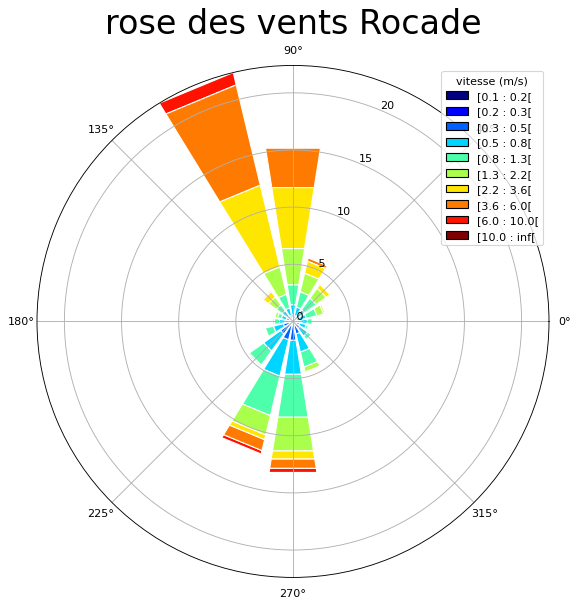

In [11]:
def jolierosedesvents(wdir, wsp, lieu,legend_xy='best', save=None):
    #faire la rose des vents
    from windrose import WindroseAxes
    mini,maxi=wsp.min(),wsp.max()

    ax = WindroseAxes.from_ax()
    ax.bar(wdir, wsp, normed=True, opening=0.8, edgecolor='white',
        # make logarithm bins in order to better see extreme winds
        bins=np.logspace(np.floor(np.log10(0.1)),np.floor(np.log10(maxi)), 10)
    )

    # graduer correctement la rose des vents
    import matplotlib.ticker as tkr
    ax.set_yticks(np.arange(0,25,5))
    for t in ax.get_yticklabels():
        print(t)
    ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f'))

    #décorer la rose des vents
    ax.set_legend()
    ax.legend(title="vitesse (m/s)", loc=legend_xy)
    plt.title('rose des vents '+lieu, fontsize=30)
    
    if save is not None: plt.savefig(save+'.jpg', dpi=300)

jolierosedesvents(mto[wdir], mto[wsp], place, 
#                   save='rosewind_Rocade'
                 )

### 3.3. Pollutant rose

Basically, a pollutant rose is nothing else than a wind rose where we replace the wind speed by a pollutant concentration. 

A difference is that in a wind rose, by convention, the direction is the wind direction, i.e. the direction from which **the wind comes** (weather convention).

Conversely, for pollutant roses, both conventions are legitimate: one can put the direction from which the wind comes, and thus the pollutants (in this case, one considers the site as a receptor). But we can also consider the site as a source site, and in this case, we want to know where the pollution we emit goes: the direction will then be the one where **the wind goes**!

**It's up to you: draw a pollution rose, and see if it fits with the previous wind rose and with your idea of the sources**.

In [13]:
def jolierosedespolluants(wdir, polval, lieu, source=True, legend_xy='best', save=None):
    #faire la rose des vents
    from windrose import WindroseAxes
    mini,maxi=polval.min(),polval.max()

    ax = WindroseAxes.from_ax()
    ax.bar(wdir, polval, blowto=source, normed=True, opening=0.8, edgecolor='white', 
           bins=np.logspace(np.floor(np.log10(0.1)),np.floor(np.log10(maxi)), 10)
           
          )

    # graduer correctement la rose des vents
    import matplotlib.ticker as tkr
    ax.set_yticks(np.arange(0,25,5))
    for t in ax.get_yticklabels():
        print(t)
    ax.yaxis.set_major_formatter(tkr.FormatStrFormatter('%2.0f'))

    #décorer la rose des vents
    ax.set_legend()
    ax.legend(title="polluant (µg/m3)", loc=legend_xy)
    plt.title('rose des polluants '+lieu, fontsize=30)
    
    if save is not None: plt.savefig(save+'.jpg', dpi=300)

Be careful: the wind direction and pollutant data must match! 

**mask the data to get vectors of the same size**

Choose the corresponding pollutant station and one pollutant.

In [14]:
mon_df = dfc['Traffic']['NO2']

pollutant = mon_df[mon_df.index.isin(mto.index)]
wind = mto[wdir][mto[wdir].index.isin(mon_df.index)]

print(len(pollutant)); print(len(wind))

48236
48236


Text(0, 0, '4.3')
Text(0, 0, '8.6')
Text(0, 0, '12.9')
Text(0, 0, '17.2')
Text(0, 0, '21.5')


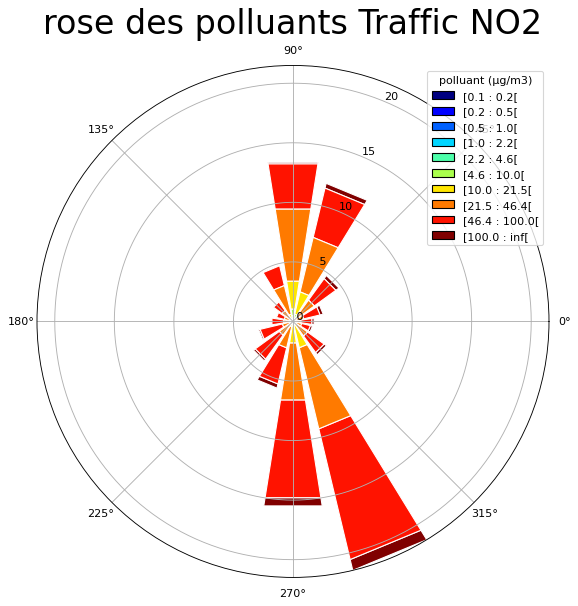

In [15]:
jolierosedespolluants(wind, pollutant, 'Traffic NO2', 
#                       save='traffic_NO2'
                     )

### 3.3 Share it on the whiteboard!

**As last time, choose a station and a pollutant that has not been chosen and add it to this map** (add a single pollutant or a wind rose so that everyone can participate): 

https://app.mural.co/t/variabiliteclimatique4363/m/variabiliteclimatique4363/1633075668320/080f4d79efeac3b94d0c9cf606bd6b7aa79dcfd6?sender=ufcbfba826e94d93c633c7410

### 3.4 Put it on map with Python

It is also possible to add these wind roses directly on a Python map thanks to [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) (but seems not to work on UGA's JupyterHub) or [Contextily](https://contextily.readthedocs.io/en/latest/). Try to find the coordinates of a station and add a wind rose or a pollutant rose at the corresponding location (https://www.atmo-auvergnerhonealpes.fr/donnees/acces-par-station/15050)!

new_station_names = {"Saint-Martin d'Heres":"Campus" , 
                     "Grenoble Rocade Sud":"Traffic" , 
                     "Grenoble les Frenes":"Urban bckgd" ,
                     "Sud grenoblois / Vif" : "Suburban South" , 
                     "Est grenoblois / Grésivaudan":"Suburban East" , 
                     "Plateau de Bonnevaux":"Regional bckgd" ,
                     "Fontaine les Balmes":"Suburban West"}

Campus
Latitude : 45.18303 °
Longitude : 5.75325 °

Rocade / Traffic
Latitude : 45.15843 °
Longitude : 5.70376 °

Vif / Suburban South
Latitude : 45.05803 °
Longitude : 5.67689 °

Suburban East
Latitude : 45.27997 °
Longitude : 5.88240 °

Regional bckgd
cham_lon, cham_lat = (5.18108, 45.46090)



<ipython-input-16-2a7fab423917>:3: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


Text(0.5, 1.05, 'windrose Traffic')

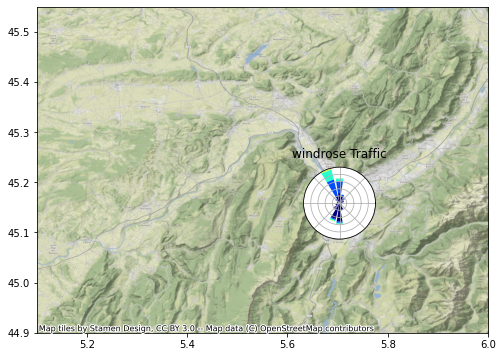

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import contextily as cx
import windrose

minlon, maxlon, minlat, maxlat = (5.1, 6, 44.9, 45.55)

_,main_ax = plt.subplots(figsize=(12, 6))

main_ax.set(xlim=(minlon, maxlon),ylim=(minlat, maxlat))
cx.add_basemap(main_ax, zoom=12, crs=4326)

# Coordinates of the station we were measuring windspeed
lon, lat = (5.70376, 45.15843)

# Inset axe it with a fixed size
wrax = inset_axes(main_ax,
        width=1,                             # size in inches
        height=1,                            # size in inches
        loc='center',                        # center bbox at given position
        bbox_to_anchor=(lon, lat),           # position of the axe
        bbox_transform=main_ax.transData,    # use data coordinate (not axe coordinate)
        axes_class=windrose.WindroseAxes,    # specify the class of the axe
        )

wrax.bar(mto[wdir], mto[wsp])
wrax.tick_params(labelleft=False, labelbottom=False)
wrax.set_title('windrose Traffic')
    
# plt.savefig('map.jpg', dpi=300, bbox_inches='tight')

Il y a plein d'autres questions qu'on pourrait se poser avec un jeu de données pareil :
- saisonalité des roses des vents ? 
- saisonalité des roses de pollution ? 
- liens plus fins entre météo et pollution : 
    - influence de la pluie sur les niveaux de pollution ? (pas si évident comme le montre la figure suivante). Il faut être un peu plus sioux pour le voir (c'est pas la pluie horaire qui compte...)
    - influence de la température sur la pollution hivernale ? (la fameuse couche d'inversion)
    - influence de l'ensoleillement, de la température sur les pics d'ozone en été ?
- liens entre $NO_X$ et $O_3$ (voir cours de Steph Houdier au S2)

...

Beaucoup de ces questions peuvent être abordées à travers les stratégies évoquées ici: split-apply-combine... pour produire les données agrégées qui nous intéressent (ex le cumul de pluie sur un événement), à comparer ensuite à une autre donnée (ex: le niveau de PM10 après événement pluvieux, ou mieux, la différence de niveau de PM10 avant - après événement pluvieux)

ex: la pluie et les niveaux de particule. 

## 6. Conclusions

Normalement, vous devriez être un peu convaincus que l'exploitation judicieuse de gros jeux de données permet de:
- représenter les données de façon parlante
- que cette représentation doit reflèter les questions qu'on se pose
- qu'elles aident alors à:
    - répondre (un peu) à ces questions
    - se représenter les phénomènes importants

Ce traitement initial et cette représentation graphique sont donc très importants, et leur pertinence est très directement fonction de:
- votre aptitude à vous poser des questions pertinentes sur votre jeu de données (expertise / curiosité / recherche)
- votre maitrise d'outils de traitement adaptés...

La curiosité, ça s'entretient ; l'expertise, ça se construit ; la compétence technique, ça se travaille...

Concernant ce dernier point en particulier: coder, c'est comme parler anglais. C'est pas une option, et c'est avant tout de la pratique. Il suffit de quelques bases. Pour le reste, google et stackoverflow sont vos amis !!! 


## 7. Remerciements

- à Air-Auvergne-Rhone-Alpes pour les données de qualité de l'air et certaines données météo
- à Jean-Paul Laurent (IGE) pour les données météo du toit du CERMO
- à Samuel Morin (Météo France) pour les données météo du Versoud
- à Théo pour m'avoir un peu forcé la main l'an dernier: j'ai beaucoup appris en écrivant ce notebook. Une semaine départ arrêté, avec seulement de vagues notions de ce qu'étaient pandas et matplotlib et au plus 1000 lignes de python à mon actif à l'époque, par petits bouts < 100 lignes ! Preuve que c'est possible...

